# Exámen Parcial : Covid-19 en Perú
### Alumno: Renzo Alessandro Sucari Velásquez

#### **DataSet**: covid-19-peru-data.csv

*   **country**: Peru (país)
*   iso3c: PER (código ISO de 3 letras para Perú)
*   **region**: Departamento del Perú (sólo a partir del 2020-03-13)
*   date: Fecha en formato ISO (YYYY-MM-DD)
*   **confirmed**: Casos confirmados
*   **deaths**: Decesos
*   **recovered**: Recuperados
*   **total_tests**: Número total de pruebas
*   **negative_tests**: Casos descartados/negativos
*   **pcr_test_positive**: Casos detectados con pruebas moleculares
*   **serological_test_positive**: Casos detectados con pruebas serológicas ("pruebas rápidas")
*   **pcr_serological_test_positive**: Casos detectados con pruebas moleculares y serológicas ("pruebas rápidas")


### Cargamos las Librerias

In [1]:
import pandas as pd # Manipulación de Estructuras (suma, resta, multiplicacion, etc.)
import numpy as np  # Manipulación de CSV 
import random       
import matplotlib.pyplot as plt # Gráficos
import datetime     # Manejo de la fecha

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

file = "covid-19-peru-data"

### Lectura de los Datos

In [2]:
def LeerDatos(filename : str):
  data = pd.read_csv(filename + ".csv", sep =',', header = 0)
  return data

In [3]:
data = LeerDatos(file)
data

,country,iso3c,region,date,confirmed,deaths,recovered,total_pcr,total_serological,total_ag,total_tests,negative_tests,pcr_test_positive,serological_test_positive,ag_test_positive,pcr_serological_test_positive
0,Peru,PER,NaN,2020-03-06,1.0,NaN,NaN,NaN,NaN,NaN,NaN,154.0,NaN,NaN,NaN,NaN
1,Peru,PER,NaN,2020-03-07,6.0,NaN,NaN,NaN,NaN,NaN,NaN,213.0,NaN,NaN,NaN,NaN
2,Peru,PER,NaN,2020-03-09,9.0,NaN,NaN,NaN,NaN,NaN,NaN,309.0,NaN,NaN,NaN,NaN
3,Peru,PER,NaN,2020-03-10,11.0,NaN,NaN,NaN,NaN,NaN,NaN,335.0,NaN,NaN,NaN,NaN
4,Peru,PER,NaN,2020-03-11,17.0,NaN,NaN,NaN,NaN,NaN,NaN,697.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15300,Peru,PER,San Martín,2021-10-13,48668.0,3000.0,NaN,37845.0,137786.0,78234.0,253865.0,205197.0,8440.0,28645.0,11583.0,NaN
15301,Peru,PER,Tacna,2021-10-13,29804.0,1950.0,NaN,14247.0,111744.0,90505.0,216496.0,186692.0,4722.0,15812.0,9270.0,NaN
15302,Peru,PER,Tumbes,2021-10-13,18783.0,1562.0,NaN,37893.0,47043.0,39448.0,124384.0,105601.0,4950.0,8970.0,4863.0,NaN
15303,Peru,PER,Ucayali,2021-10-13,32095.0,3091.0,NaN,18420.0,87996.0,50246.0,156662.0,124567.0,2642.0,21976.0,7477.0,NaN


In [4]:
values = {'region' : 'Peru' }
data.fillna(value = values, inplace = True)
regiones = data.groupby(['region'])
peru_datos = regiones.get_group('Peru')
peru_datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586 entries, 0 to 15304
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country                        586 non-null    object 
 1   iso3c                          586 non-null    object 
 2   region                         586 non-null    object 
 3   date                           586 non-null    object 
 4   confirmed                      585 non-null    float64
 5   deaths                         573 non-null    float64
 6   recovered                      575 non-null    float64
 7   total_pcr                      74 non-null     float64
 8   total_serological              74 non-null     float64
 9   total_ag                       74 non-null     float64
 10  total_tests                    553 non-null    float64
 11  negative_tests                 585 non-null    float64
 12  pcr_test_positive              550 non-null    f

In [5]:
# Pandas: Generamos estadísticas descriptivas
peru_datos.describe()

,confirmed,deaths,recovered,total_pcr,total_serological,total_ag,total_tests,negative_tests,pcr_test_positive,serological_test_positive,ag_test_positive,pcr_serological_test_positive
count,5.850000e+02,573.000000,5.750000e+02,7.400000e+01,7.400000e+01,7.400000e+01,5.530000e+02,5.850000e+02,550.000000,549.000000,2.810000e+02,2.000000
mean,1.109021e+06,69272.486911,1.053031e+06,5.033341e+06,5.185189e+06,6.779995e+06,7.581642e+06,6.058348e+06,329584.181818,662275.459016,3.726420e+05,207.500000
std,7.461012e+05,72245.145291,7.559689e+05,2.411236e+05,2.828498e+04,5.649120e+05,5.573462e+06,4.958139e+06,224395.114118,309135.061492,2.865752e+05,33.234019
min,1.000000e+00,3.000000,1.000000e+00,4.630331e+06,5.133208e+06,5.788683e+06,3.959900e+04,1.540000e+02,2281.000000,484.000000,2.600000e+02,184.000000
25%,4.147350e+05,21072.000000,3.123345e+05,4.826500e+06,5.161050e+06,6.308614e+06,3.006993e+06,1.933661e+06,149696.000000,444878.000000,1.524860e+05,195.750000
50%,1.003982e+06,37621.000000,9.474270e+05,5.029291e+06,5.185360e+06,6.792823e+06,5.651113e+06,4.429186e+06,248466.000000,786042.000000,4.417270e+05,207.500000
75%,1.903615e+06,67807.000000,1.861233e+06,5.234504e+06,5.212003e+06,7.272157e+06,1.267576e+07,1.033704e+07,581865.750000,918788.000000,5.516380e+05,219.250000
max,2.186246e+06,199746.000000,2.163578e+06,5.446721e+06,5.226747e+06,7.693849e+06,1.836732e+07,1.618107e+07,889950.000000,946098.000000,3.659446e+06,231.000000


### Visualización de los datos

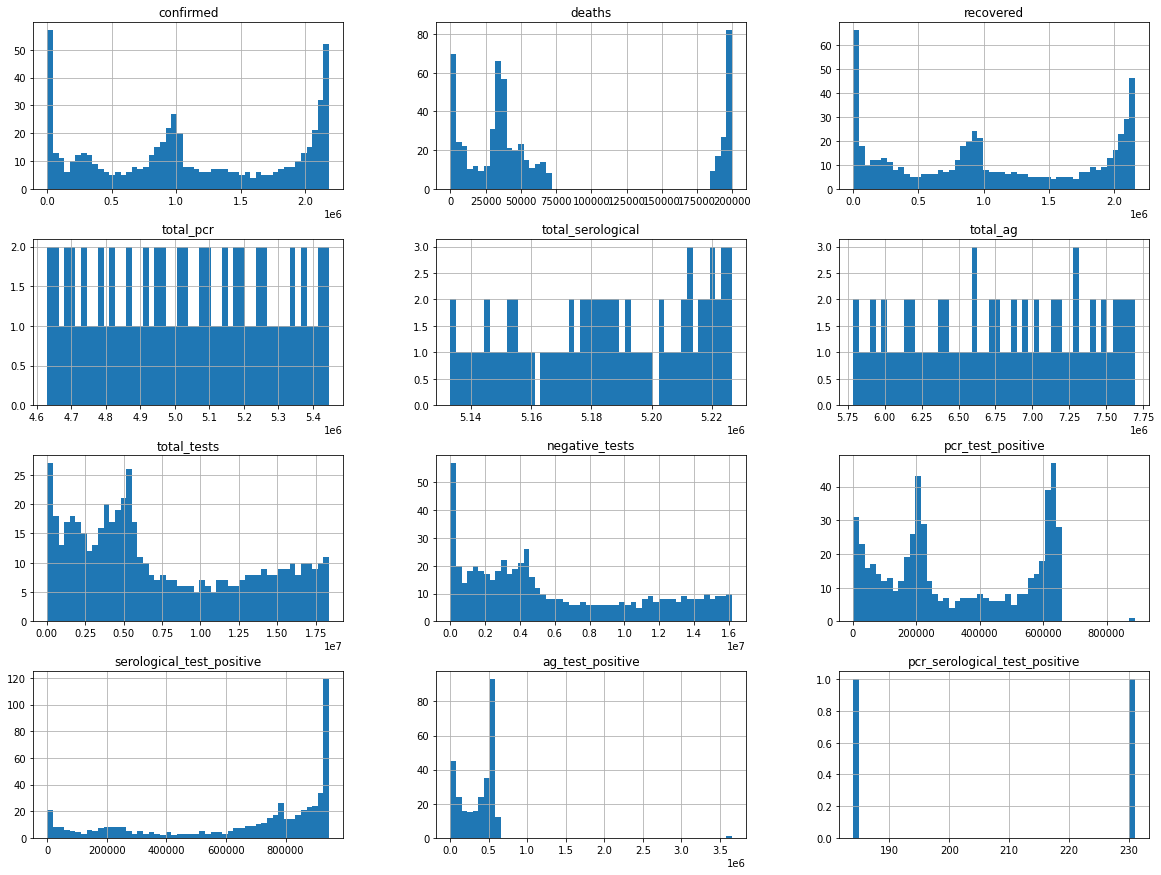

In [6]:
# Matplotlib: Distribuciones de cada variable
%matplotlib inline
import matplotlib.pyplot as plt
peru_datos.hist(bins=50, figsize=(20,15))
plt.show()

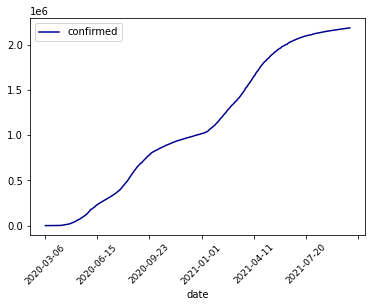

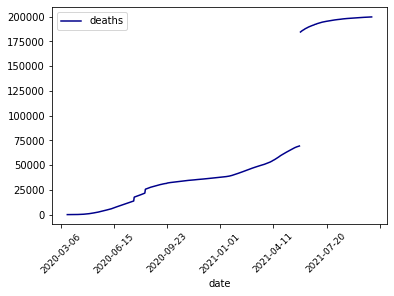

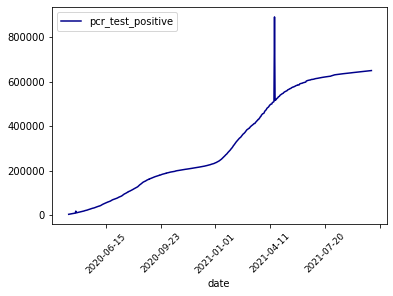

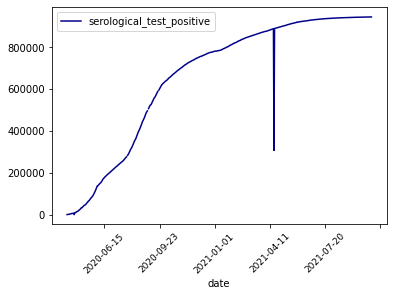

In [7]:
peru_datos.plot.line(x='date',y='confirmed', c='DarkBlue')
plt.xticks(fontsize = 9, rotation=45)
peru_datos.plot.line(x='date',y='deaths', c='DarkBlue')
plt.xticks(fontsize = 9, rotation=45)
peru_datos.plot.line(x='date',y='pcr_test_positive', c='DarkBlue')
plt.xticks(fontsize = 9, rotation=45)
peru_datos.plot.line(x='date',y='serological_test_positive', c='DarkBlue')
plt.xticks(fontsize = 9, rotation=45)
#save_fig("attribute_histogram_plots")
plt.show()

In [8]:
peru_datos.drop(labels = ['recovered','negative_tests','pcr_serological_test_positive'], axis = 1)
peru_datos.reset_index()

,index,country,iso3c,region,date,confirmed,deaths,recovered,total_pcr,total_serological,total_ag,total_tests,negative_tests,pcr_test_positive,serological_test_positive,ag_test_positive,pcr_serological_test_positive
0,0,Peru,PER,Peru,2020-03-06,1.0,NaN,NaN,NaN,NaN,NaN,NaN,154.0,NaN,NaN,NaN,NaN
1,1,Peru,PER,Peru,2020-03-07,6.0,NaN,NaN,NaN,NaN,NaN,NaN,213.0,NaN,NaN,NaN,NaN
2,2,Peru,PER,Peru,2020-03-09,9.0,NaN,NaN,NaN,NaN,NaN,NaN,309.0,NaN,NaN,NaN,NaN
3,3,Peru,PER,Peru,2020-03-10,11.0,NaN,NaN,NaN,NaN,NaN,NaN,335.0,NaN,NaN,NaN,NaN
4,4,Peru,PER,Peru,2020-03-11,17.0,NaN,NaN,NaN,NaN,NaN,NaN,697.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,15196,Peru,PER,Peru,2021-10-09,2183589.0,199641.0,2160784.0,5403792.0,5224394.0,7612836.0,18241022.0,16057433.0,648281.0,945942.0,589366.0,NaN
582,15223,Peru,PER,Peru,2021-10-10,2184264.0,199672.0,2161439.0,5415964.0,5224693.0,7632648.0,18273305.0,16089041.0,648503.0,945981.0,589780.0,NaN
583,15250,Peru,PER,Peru,2021-10-11,2184676.0,199703.0,2161893.0,5423018.0,5224895.0,7641404.0,18289317.0,16104641.0,648643.0,946004.0,590029.0,NaN
584,15277,Peru,PER,Peru,2021-10-12,2185355.0,199727.0,2162620.0,5433349.0,5225561.0,7665557.0,18324467.0,16139112.0,648834.0,946046.0,590475.0,NaN


In [9]:
# Pandas: Accedemos a un grupo de columnas por etiqueta
fechas = peru_datos.loc[:,['date']]
confirmados = peru_datos.loc[:,['confirmed']]
fallecidos = peru_datos.loc[:,['deaths']]
recuperados = peru_datos.loc[:,['recovered']]

In [10]:
confimados_sum = confirmados.iloc[-1]
fallecidos_sum = fallecidos.iloc[-1]
recuperados_sum = recuperados.iloc[-1]

In [11]:
# Pandas: Conviertimos el DataFrame en una array NumPy.
peru_casos = confirmados.to_numpy()
peru_fallecidos = fallecidos.to_numpy()
peru_recuperados = recuperados.to_numpy()
peru_activos = peru_casos - peru_fallecidos - peru_recuperados
tasa_mortalidad = peru_fallecidos / peru_casos
tasa_recuperacion = peru_recuperados/ peru_casos

In [12]:
def incremento_diario(data):
    diario = []
    diario.append(data[0])
    for i in range(1,len(data)):
            diario.append(data[i]-data[i-1])
    return diario  

In [13]:
incremento_diario_peru = incremento_diario(peru_casos)
fallecidos_diarios_peru = incremento_diario(peru_fallecidos)
recuperados_diarios_peru = incremento_diario(peru_recuperados)

### La predicción debe realizarse en un rango del 18 agosto al 11 de octubre 2021.

In [14]:
# Numpy: Nuevo array desde la fecha
days_since_18_8 = np.array([range(len(fechas))]).reshape(-1,1)

In [15]:
# Numpy: Nuevo array desde: fechas + dias futuros
dias_futuros = 54
pronostico_futuro = np.array([range(len(fechas)+dias_futuros)]).reshape(-1,1)
adjusted_dates = pronostico_futuro[:-54]

In [16]:
# Generamos la lista de fechas futuras a pronosticas
inicio = '18/08/2021'
fecha_de_inicio = datetime.datetime.strptime(inicio, '%d/%m/%Y')
fechas_pronostico_futuras = []
for i in range(len(pronostico_futuro)):
    fechas_pronostico_futuras.append((fecha_de_inicio + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

### Preparamos los datos para los algoritmos de Machine Learning

#### Reemplazamos los datos NaN con ceros

In [17]:
# PERU: Reemplazar NaN con cero
peru_casos = np.nan_to_num(peru_casos, np.nan)
peru_fallecidos = np.nan_to_num(peru_fallecidos, np.nan)

# Sklearn: Division de los datos: train(60%) y test(40%) 
X_train_confirmados, X_test_confirmados, y_train_confirmados, y_test_confirmados = train_test_split(days_since_18_8, peru_casos, test_size=0.42, shuffle=False)
X_train_fallecidos, X_test_fallecidos, y_train_fallecidos, y_test_fallecidos = train_test_split(days_since_18_8, peru_fallecidos, test_size=0.42, shuffle=False)

# Suport Vector Machine (SVM)

#### SVM: Para casos Confirmados y Fallecimientos

In [18]:
# Sklearn: SVM

# SVM para casos confirmados
svm_confirmados = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1.5,degree=4, C=.1)
svm_confirmados.fit(X_train_confirmados, y_train_confirmados)       # Entrenar
svm_pred_confirmados = svm_confirmados.predict(pronostico_futuro)   # Predecir    

# SVM para fallecidos
svm_fallecidos = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1.5,degree=4, C=.1)
svm_fallecidos.fit(X_train_fallecidos, y_train_fallecidos)          # Entrenar
svm_pred_fallecidos = svm_fallecidos.predict(pronostico_futuro)     # Predecir

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Calculo del Error

Error Absoluto Medio (MAE): 3245652.800895385
Error Cuadrático Medio(MSE): 16815672219487.76


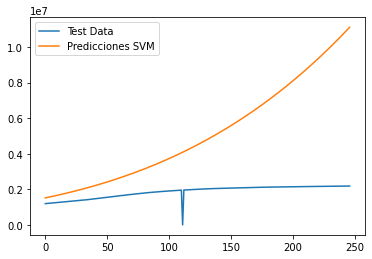

In [19]:
# Calculo del Error: Para prediccion casos
svm_test_confirmados = svm_confirmados.predict(X_test_confirmados)

plt.plot(y_test_confirmados)
plt.plot(svm_test_confirmados)
plt.legend(['Test Data', 'Predicciones SVM'])
print('Error Absoluto Medio (MAE):', mean_absolute_error(svm_test_confirmados, y_test_confirmados))
print('Error Cuadrático Medio(MSE):', mean_squared_error(svm_test_confirmados, y_test_confirmados))

Error Absoluto Medio (MAE): 106178.83001359833
Error Cuadrático Medio(MSE): 17692694585.75446


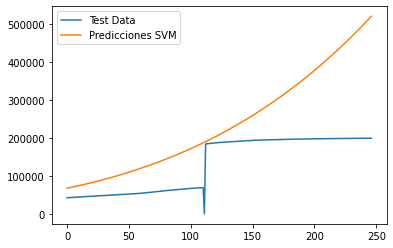

In [20]:
# Calculo del error: Para prediccion muertes
svm_test_pred_fallecidos = svm_fallecidos.predict(X_test_fallecidos) 

plt.plot(y_test_fallecidos)
plt.plot(svm_test_pred_fallecidos)
plt.legend(['Test Data', 'Predicciones SVM'])
print('Error Absoluto Medio (MAE):', mean_absolute_error(svm_test_pred_fallecidos, y_test_fallecidos))
print('Error Cuadrático Medio(MSE):', mean_squared_error(svm_test_pred_fallecidos, y_test_fallecidos))

# Regresión Polinomial (RP)

### Transformación de los datos para RP

In [21]:
# Transformacion de data para Regresion Polinomial
poly = PolynomialFeatures(degree=2)
# El modelo aprende (la media y la varianza): Casos 
poly_X_train_confirmados = poly.fit_transform(X_train_confirmados) # Para entrenar
poly_X_test_confirmados = poly.fit_transform(X_test_confirmados)   # Para predecir
# El modelo aprende (la media y la varianza): Fallecidos
poly_X_train_fallecidos = poly.fit_transform(X_train_fallecidos)   # Para entrenar
poly_X_test_fallecidos = poly.fit_transform(X_test_fallecidos)     # Para predecir
# El modelo aprende (la media y la varianza): Futuro
poly_pronostico_futuro = poly.fit_transform(pronostico_futuro)

## RP: Para casos Confirmados

In [22]:
# Regresion Polinomial: Para casos Confirmados
linear_model_confirmados = LinearRegression(normalize=True, fit_intercept=False)
linear_model_confirmados.fit(poly_X_train_confirmados, y_train_confirmados)         # Entrenar
test_linear_confirmados = linear_model_confirmados.predict(poly_X_test_confirmados) # Predecir
linear_pred_confirmados = linear_model_confirmados.predict(poly_pronostico_futuro)
print('Error Absoluto Medio (MAE):', mean_absolute_error(test_linear_confirmados, y_test_confirmados))
print('Error Cuadrático Medio(MSE):', mean_squared_error(test_linear_confirmados, y_test_confirmados))

Error Absoluto Medio (MAE): 287061.0929118808
Error Cuadrático Medio(MSE): 102773743859.11823


In [23]:
# Coeficientes estimados para el problema de regresión lineal
print(linear_model_confirmados.coef_)

[[-1.53959418e+05  4.55383555e+03 -1.63385910e+00]]


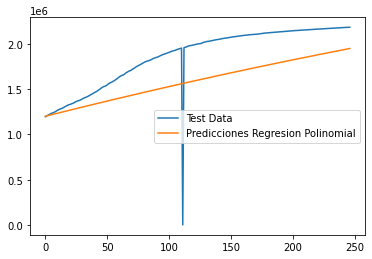

In [24]:
plt.plot(y_test_confirmados)
plt.plot(test_linear_confirmados)
plt.legend(['Test Data', 'Predicciones Regresion Polinomial'])

## RP: Para casos Fallecimientos

In [25]:
# Regresion Polinomial: Para Fallecimientos
linear_model_fallecidos = LinearRegression(normalize=True, fit_intercept=False)
linear_model_fallecidos.fit(poly_X_train_fallecidos, y_train_fallecidos)              # Entrenar
test_linear_pred_fallecidos = linear_model_fallecidos.predict(poly_X_test_fallecidos) # Predecir
linear_pred_fallecidos = linear_model_fallecidos.predict(poly_pronostico_futuro)
print('Error Absoluto Medio (MAE):', mean_absolute_error(test_linear_pred_fallecidos, y_test_fallecidos))
print('Error Cuadrático Medio(MSE):',mean_squared_error(test_linear_pred_fallecidos, y_test_fallecidos))

Error Absoluto Medio (MAE): 82169.04184552991
Error Cuadrático Medio(MSE): 11316167726.029327


In [26]:
# Coeficientes estimados para el problema de regresión lineal
print(linear_model_fallecidos.coef_)

[[-7.80679238e+03  2.15221254e+02 -1.91536132e-01]]


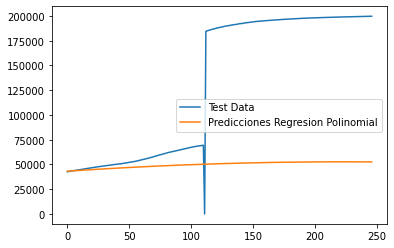

In [27]:
plt.plot(y_test_fallecidos)
plt.plot(test_linear_pred_fallecidos)
plt.legend(['Test Data', 'Predicciones Regresion Polinomial'])

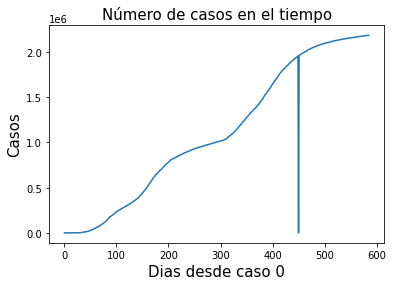

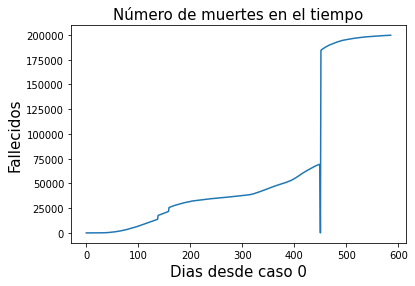

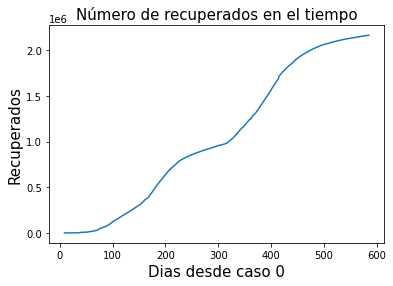

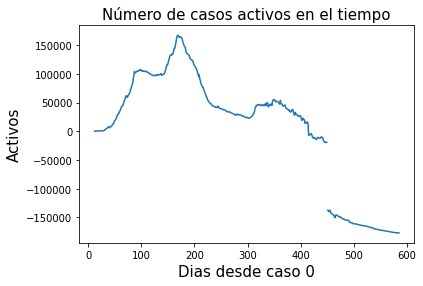

In [28]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]

#plt.figure(figsize=(8, 4.5))
plt.plot(adjusted_dates, peru_casos)
plt.title('Número de casos en el tiempo', size=15)
plt.xlabel('Dias desde caso 0', size=15)
plt.ylabel('Casos', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

#plt.figure(figsize=(8, 4.5))
plt.plot(adjusted_dates, peru_fallecidos)
plt.title('Número de muertes en el tiempo', size=15)
plt.xlabel('Dias desde caso 0', size=15)
plt.ylabel('Fallecidos', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

#plt.figure(figsize=(8, 4.5))
plt.plot(adjusted_dates, peru_recuperados)
plt.title('Número de recuperados en el tiempo', size=15)
plt.xlabel('Dias desde caso 0', size=15)
plt.ylabel('Recuperados', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

#plt.figure(figsize=(8, 4.5))
plt.plot(adjusted_dates, peru_activos)
plt.title('Número de casos activos en el tiempo', size=15)
plt.xlabel('Dias desde caso 0', size=15)
plt.ylabel('Activos', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

## Visualización de las predicciones: SVM y Regresión Polinomial

In [29]:
def plot_predictions(x, y, pred, algo_name, color, title):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(pronostico_futuro, pred, linestyle='dashed', color=color)
    plt.title('Número de ' + title + ' en el tiempo', size=25)
    plt.xlabel('Días desde caso 0', size=25)
    plt.ylabel(title, size=25)
    plt.legend([ title +' confirmados', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

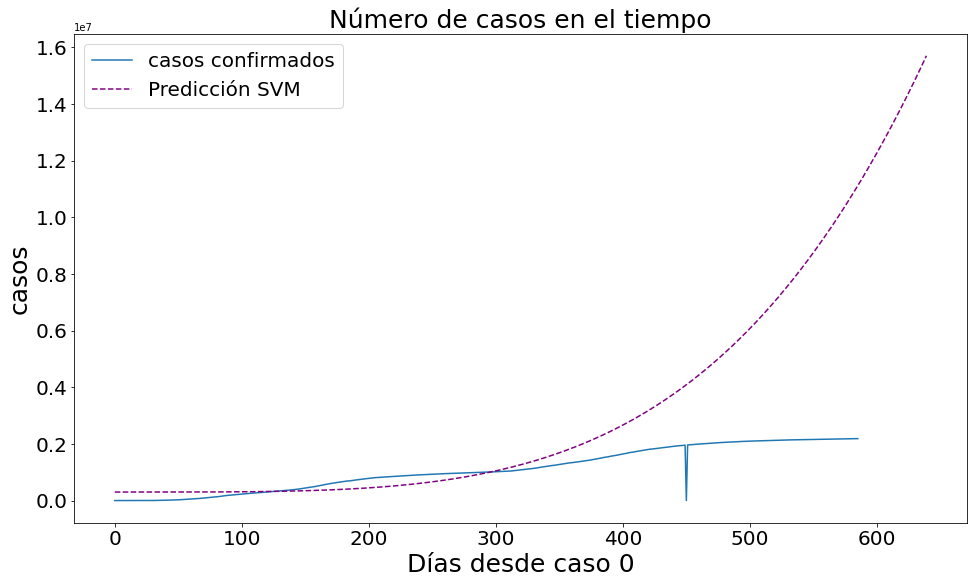

In [30]:
plot_predictions(adjusted_dates, peru_casos, svm_pred_confirmados, 'Predicción SVM', 'purple', 'casos')

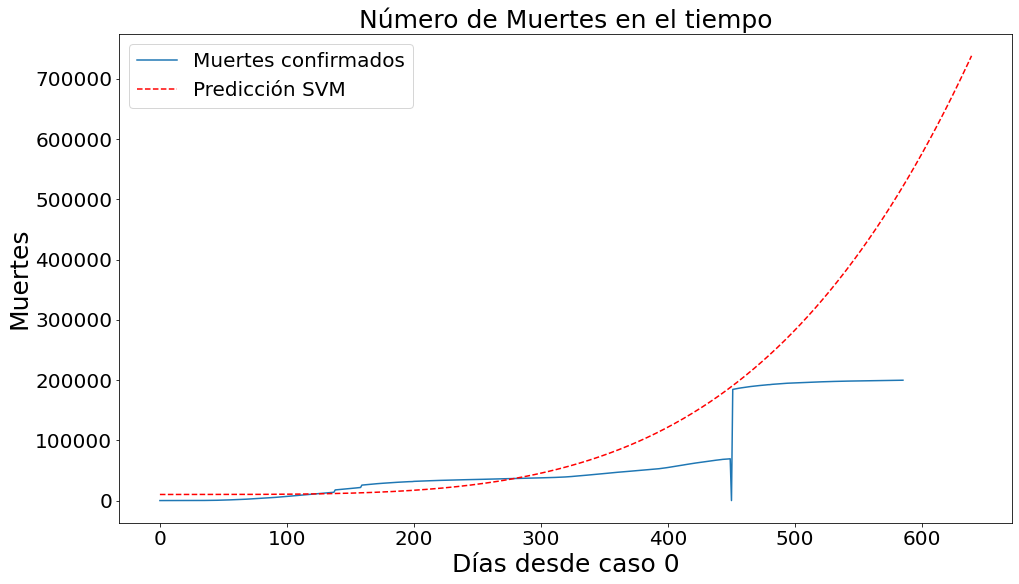

In [31]:
plot_predictions(adjusted_dates, peru_fallecidos, svm_pred_fallecidos, 'Predicción SVM', 'red', 'Muertes')

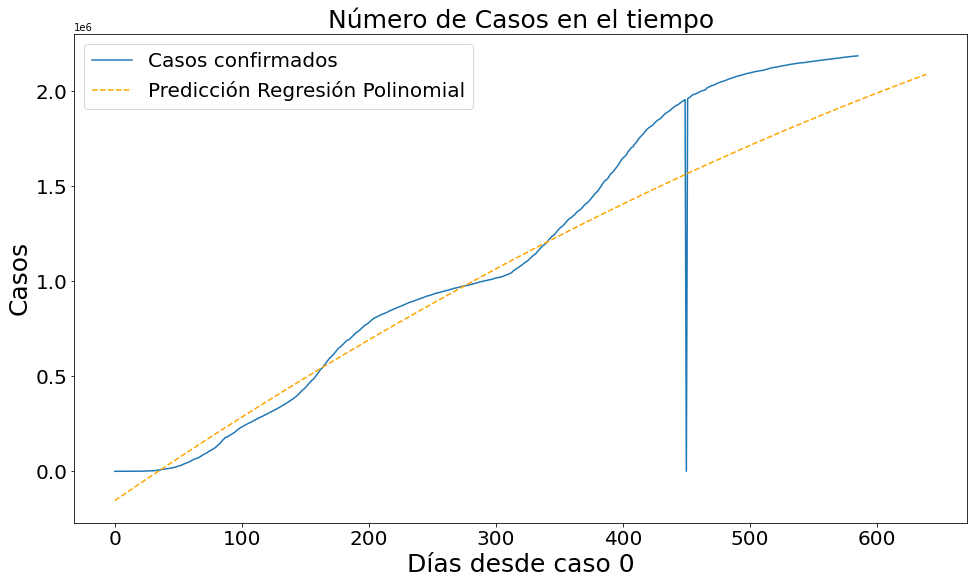

In [32]:
plot_predictions(adjusted_dates, peru_casos, linear_pred_confirmados, 'Predicción Regresión Polinomial', 'orange', 'Casos')

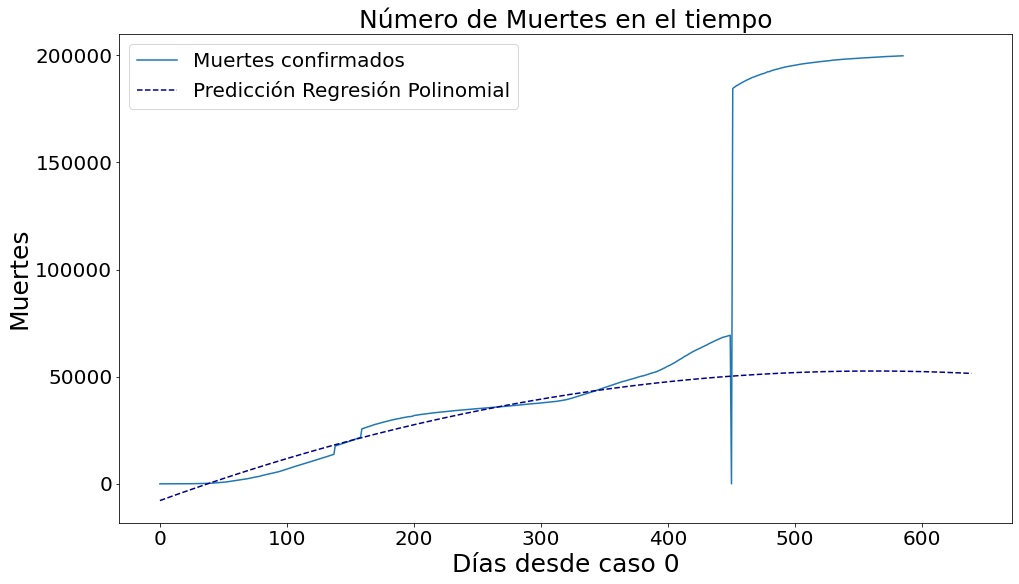

In [33]:
plot_predictions(adjusted_dates, peru_fallecidos, linear_pred_fallecidos, 'Predicción Regresión Polinomial', 'darkblue', 'Muertes')

In [34]:
# Predicciones futuras usando SVM
svm_df = pd.DataFrame({'Fecha': fechas_pronostico_futuras[:66], 'Casos': np.round(svm_pred_confirmados[:66]),'Muertes':np.round(svm_pred_fallecidos[:66])})
svm_df

,Fecha,Casos,Muertes
0,08/18/2021,300389.0,10100.0
1,08/19/2021,300389.0,10100.0
2,08/20/2021,300389.0,10100.0
3,08/21/2021,300389.0,10100.0
4,08/22/2021,300389.0,10100.0
...,...,...,...
61,10/18/2021,301668.0,10161.0
62,10/19/2021,301754.0,10165.0
63,10/20/2021,301844.0,10169.0
64,10/21/2021,301939.0,10174.0


In [35]:
# Predicciones futuras usando Regresion Polinomial
linear_pred_confirmados = linear_pred_confirmados.reshape(1,-1)[0]
linear_pred_fallecidos = linear_pred_fallecidos.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Fecha': fechas_pronostico_futuras[:66], 'Casos': np.round(linear_pred_confirmados[:66]),'Muertes':np.round(linear_pred_fallecidos[:66])})
svm_df

,Fecha,Casos,Muertes
0,08/18/2021,-153959.0,-7807.0
1,08/19/2021,-149407.0,-7592.0
2,08/20/2021,-144858.0,-7377.0
3,08/21/2021,-140313.0,-7163.0
4,08/22/2021,-135770.0,-6949.0
...,...,...,...
61,10/18/2021,117745.0,4609.0
62,10/19/2021,122098.0,4801.0
63,10/20/2021,126447.0,4992.0
64,10/21/2021,130794.0,5183.0


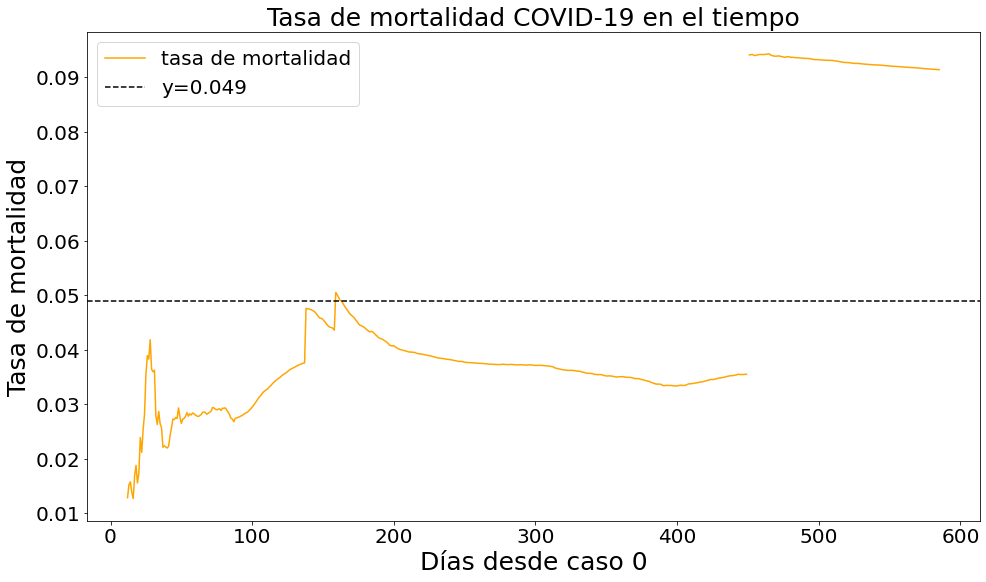

In [36]:
mean_tasa_mortalidad = np.round(np.nanmean(tasa_mortalidad),4) # Media aritmetica
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, tasa_mortalidad, color='orange')
plt.axhline(y = mean_tasa_mortalidad,linestyle='--', color='black')
plt.title('Tasa de mortalidad COVID-19 en el tiempo', size=25)
plt.legend(['tasa de mortalidad', 'y='+str(mean_tasa_mortalidad)], prop={'size': 20})
plt.xlabel('Días desde caso 0', size=25)
plt.ylabel('Tasa de mortalidad', size=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

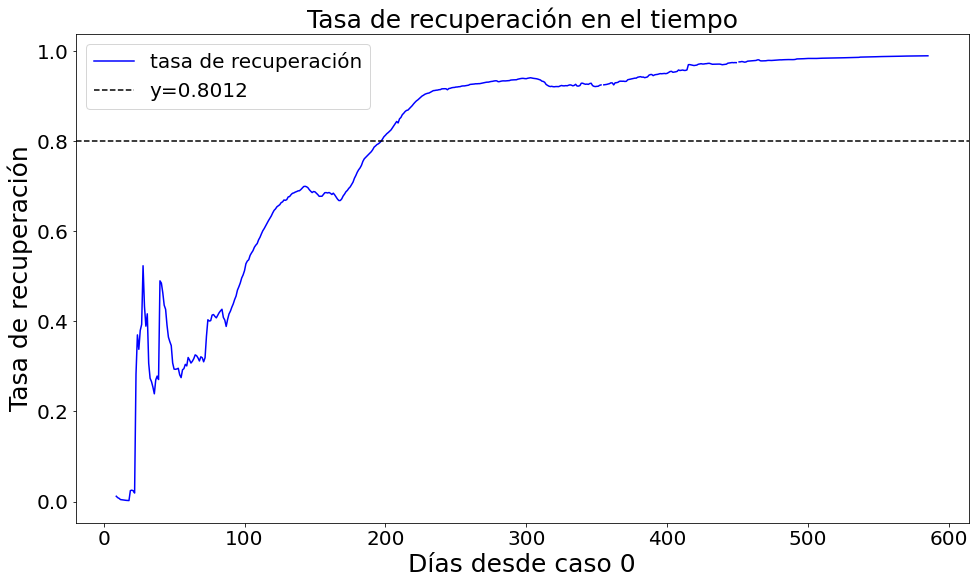

In [37]:
mean_tasa_recuperacion = np.round(np.nanmean(tasa_recuperacion),4) # Media aritmetica
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, tasa_recuperacion, color='blue')
plt.axhline(y = mean_tasa_recuperacion,linestyle='--', color='black')
plt.title('Tasa de recuperación en el tiempo', size=25)
plt.legend(['tasa de recuperación', 'y='+str(mean_tasa_recuperacion)], prop={'size': 20})
plt.xlabel('Días desde caso 0', size=25)
plt.ylabel('Tasa de recuperación', size=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# Programación: Regresión Lineal + Gradiente Descendiente


## 1.  Normalización con el Promedio (Buena Practica)
Nos ayuda a extender o comprimir los valores de la variable para que estén en un rango definido. Esto ayudará evitar que el modelo falle y aceleramos la convergencia

Función de Normalización:

$X_{i} = \frac{X_i - \mu_i}{S_i}$

donde:

  - $\mu_i$ : Media
  - $S_i$ : Desviación estándar



In [38]:
def Normalizar_Datos(data : np.array):
    normal = np.empty_like(data)
    for i in range (0,np.size(data[0])):
        media = np.mean(data[:,i])
        desvi =np.std(data[:,i])
        normal[:,i] = (data[:,i] - media)/desvi
    return normal, media, desvi

In [39]:
X_train_confirmados, X_test_confirmados, y_train_confirmados, y_test_confirmados = train_test_split(days_since_18_8, peru_casos, test_size=0.1, shuffle=False)
X_train_fallecidos, X_test_fallecidos, y_train_fallecidos, y_test_fallecidos = train_test_split(days_since_18_8, peru_fallecidos, test_size=0.1, shuffle=False)

In [40]:
X_train_fallecidos_n = X_train_fallecidos.astype('float64')
y_train_fallecidos_n = y_train_fallecidos.astype('float64')

X_train_fallecidos_n, med_X_train_fallecidos, des_X_train_fallecidos = Normalizar_Datos(X_train_fallecidos_n)
y_train_fallecidos_n, med_y_train_fallecidos, des_y_train_fallecidos = Normalizar_Datos(y_train_fallecidos_n)
#X_train_fallecidos_n

## 2.  Calcular Costos
La función de costo nos ayuda que tan incorrecto es el modelo en terminos de su capacidad para estimar la relación entre X e y.

Función de Costo:

$J(\theta) = J(\theta_0, \theta_1, ..., \theta_n ) = \frac{1}{2m} \sum_{i=1}^m (h_{\theta}(x^{(i)})-y^{(i)})^2$

Donde:

- Parámetros : $\theta_0, \theta_1, ..., \theta_n$ 
- Predicción : $h_{\theta}(x^{(i)})$
- Respuesta correcta : $y^{(i)}$

In [41]:
def Calcular_Costo(X: np.array, y: np.array, theta: np.array):
    m = np.size(X[:,0]) # numero de datos
    #Calculo de la Hipotesis : h(x)
    h = X.dot(theta.T)
    h = h - y
    return np.sum( np.square(h) ) / (2*m) , h

## 3.  Gradiente Descendiente
Una vez que definamos la función de costo para nuestro modelo, tendremos que averiguar cómo asignar valores a $\theta_j$ de manera que el error para nuestro modelo sea mínimo. Se comienza con algún valor de los parámetros y luego estos van a estar cambiando repetidamente los parámetros de modo que terminemos con un error minimo para nuestro conjunto de datos de entremaniento usando nuestra funcion de modelo.

Función de Gradiente Descendiente:

$\theta_j := \theta_j - \alpha \frac{\partial}{\partial\theta_j} J(\theta_0, \theta_1, ..., \theta_n )$

$\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^{(i)})-y^{(i)})x_j^{(i)}$

Donde: 

*   Tasa de Aprendizaje: $\alpha$ 




In [42]:
def Gradiente_Descendiente(X: np.array, y:np.array, theta:np.array,
                          num_itera:int, tasa_apren:float):
    m = np.size(X[:,0]) #numero de datos
    arr_costo = np.zeros(num_itera, dtype=float)   
    #Calculo con valor inicial
    arr_costo[0], h = Calcular_Costo(X, y, theta)
    #Iteraciones
    for itera in range(1,num_itera):
        theta = theta - ( tasa_apren * (np.dot(h, X)/m))      
        arr_costo[itera], h = Calcular_Costo(X, y, theta)
    return arr_costo, theta

In [43]:
def InicializarXo(X: np.array):
    #Funcion para Insertar Columna X0 = 1 
    one = np.ones( (len(X)) )
    return np.c_[ (one, X)]

## 4.  Ecuación Normal
Método para encontrar $\theta$ de forma analítica.

Función de la Ecuacion Normal:

$\theta = (X^T X)^{-1} X^{T}y$

Donde:
*  $X^T$: Es la transpuesta de $X$  
*  $(X^T X)^{-1}$: Es la inversa de la matriz $X^T X$

In [44]:
def Ecuacion_Normal(X :np.array , y:np.array):
    XT = np.transpose(X)
    return np.dot(np.dot( np.linalg.inv( np.dot(XT, X)) , XT) , y)

## 5.  Error Cuadrático Medio
Método para evaluar el error para ambos conjuntos.

Función de la RMS:

$E_{RMS} = \frac{1}{N} \sum_{i=1}^N (y_i - \widehat{y}_i)^2$

In [45]:
def Error_Cuadratico_Medio(x_test: np.array, y_test: np.array, theta:np.array):
    n = np.size(y_test)
    #y_calc = np.empty(n)
    y_calc = x_test.dot(theta)
    #print(x_test)
    return (np.sum(np.square(y_calc-y_test)))/n

In [46]:
#Valores Theta para Gradiente Descendiente
def CalculoTheta(X:np.array, y:np.array):
    y_train = []
    X_train = InicializarXo(X)
    for i in y:
        y_train.append(i[0])
 
    theta = np.zeros( (np.size(X_train[0])))
    dummy, theta = (Gradiente_Descendiente(X_train, y_train, theta, 200, 0.2))
    
    theta_ec = Ecuacion_Normal(X_train, y_train)
    # Como se esta comportando mi modelo
    error = Error_Cuadratico_Medio(X_train, y_train, theta)
    return theta, theta_ec, error, dummy

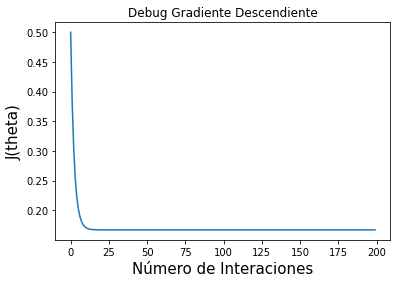

array([5.96613208e-17, 8.16387134e-01])

In [47]:
theta_calc, theta_ec, error, cost_history = CalculoTheta(X_train_fallecidos_n, y_train_fallecidos_n)
plt.title("Debug Gradiente Descendiente")
plt.plot(cost_history)
plt.xlabel('Número de Interaciones', size=15)
plt.ylabel('J(theta)', size=15)
plt.show()
# Valores theta por la gradiente descendiente
theta_calc

In [48]:
# Valores theta por la Ec. Normal
theta_ec, error

(array([-1.92554306e-16,  8.16387134e-01]), 0.33351204738964824)

In [49]:
# Preparacion de data para prediccion
pronostico_futuro_n = pronostico_futuro.astype('float64')
# Normalización
pronostico_futuro_n = (pronostico_futuro_n - med_X_train_fallecidos)/des_X_train_fallecidos
# Por conveniencia: Agregamos el X_0 = 1
pronostico_futuro_n = InicializarXo(pronostico_futuro_n)
# Hipotesis
y_pred_fallecidos = pronostico_futuro_n.dot(theta_calc)
# Desnormalizamos
y_pred_fallecidos = (y_pred_fallecidos * des_y_train_fallecidos)+med_y_train_fallecidos

In [50]:
# Presentacion de Resultados
y_pred_death_df = pd.DataFrame({'Fecha': fechas_pronostico_futuras[:10], 'Muertes':np.round(y_pred_fallecidos[:10])})
y_pred_death_df

,Fecha,Muertes
0,08/18/2021,-32121.0
1,08/19/2021,-31797.0
2,08/20/2021,-31473.0
3,08/21/2021,-31149.0
4,08/22/2021,-30825.0
5,08/23/2021,-30501.0
6,08/24/2021,-30177.0
7,08/25/2021,-29853.0
8,08/26/2021,-29530.0
9,08/27/2021,-29206.0


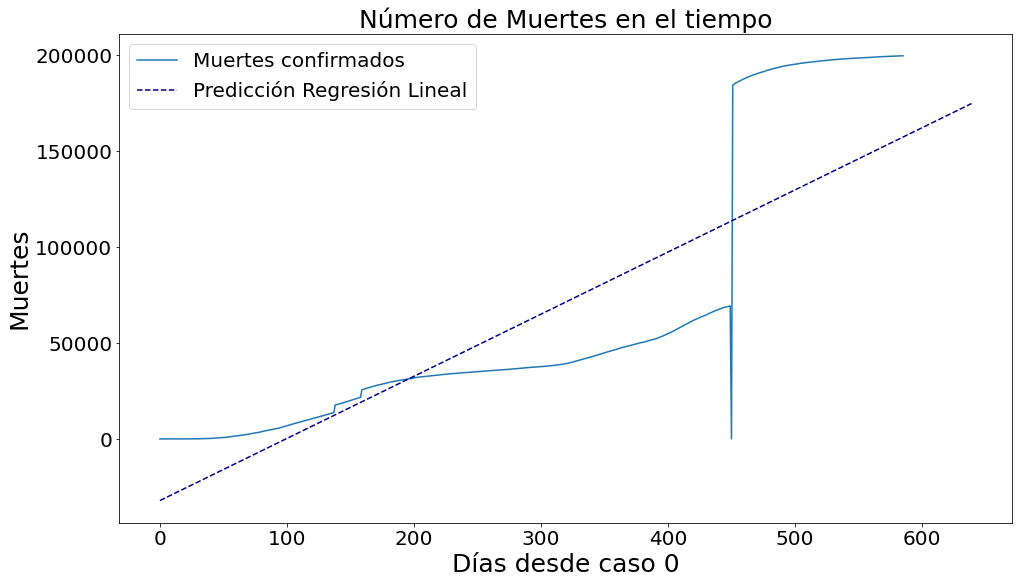

In [51]:
plot_predictions(adjusted_dates, peru_fallecidos, y_pred_fallecidos, 'Predicción Regresión Lineal', 'darkblue', 'Muertes')

In [52]:
#Toma de data para Regresion lineal multiple
X_train_fallecidos, X_test_fallecidos, y_train_fallecidos, y_test_fallecidos = train_test_split(days_since_18_8, peru_fallecidos, test_size=0.1, shuffle=False)
X_train_confirmados, X_test_confirmados, y_train_confirmados, y_test_confirmados = train_test_split(days_since_18_8, peru_casos, test_size=0.1, shuffle=False)

In [53]:
#Preparacion de data para Regresion lineal multiple
X_train_confirmados = X_train_confirmados.astype('float64')
y_train_confirmados = y_train_confirmados.astype('float64')

X_train_confirmados_n, mid_X_train, svi_X_train = Normalizar_Datos(X_train_confirmados)
y_train_confirmados_n, mid_y_train, svi_y_train = Normalizar_Datos(y_train_confirmados)

X_train_fecha_conf = np.c_[ (X_train_confirmados_n, y_train_confirmados_n)]
X_train_fecha_conf

array([[-1.7287673 , -1.42662183],
       [-1.72219404, -1.42661462],
       [-1.71562078, -1.42661029],
       ...,
       [ 1.71562078,  1.64779759],
       [ 1.72219404,  1.64995699],
       [ 1.7287673 ,  1.65136774]])

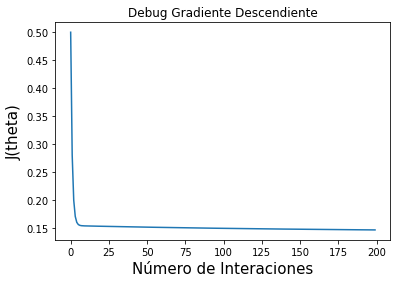

(array([-8.00540321e-18,  2.95094241e-02,  8.05343632e-01]),
 0.29237155138381243)

In [54]:
theta_n , theta_ec_n, error_n, cost_history_n = CalculoTheta(X_train_fecha_conf, y_train_fallecidos_n)
plt.title("Debug Gradiente Descendiente")
plt.plot(cost_history_n)
plt.xlabel('Número de Interaciones', size=15)
plt.ylabel('J(theta)', size=15)
plt.show()
#Valores theta por la gradiente descendiente
theta_n, error_n

In [55]:
#Utilizamos la data de la prediccion de SVM para completar data para prediccion
#Normalizamos
svm_pred_n = (svm_pred_confirmados - mid_y_train)/svi_y_train
#svm_pred_n

In [56]:
#Preparamos X para calculo de y prediccion
x_future_calc_n = np.c_[(pronostico_futuro_n, svm_pred_n)]
#x_future_calc_n

In [57]:
#Prediccion 
y_future_calc_n = x_future_calc_n.dot(theta_n)
#y_future_calc_n

In [58]:
#Desnormalizacion y Presentacion de Resultados
y_future_calc_n = (y_future_calc_n * des_y_train_fallecidos) + med_y_train_fallecidos

y_multi_death_df = pd.DataFrame({'Fecha': fechas_pronostico_futuras[:66], 'Muertes':np.round(y_future_calc_n[:66])})
y_multi_death_df

,Fecha,Muertes
0,08/18/2021,1702.0
1,08/19/2021,1714.0
2,08/20/2021,1725.0
3,08/21/2021,1737.0
4,08/22/2021,1749.0
...,...,...
61,10/18/2021,2506.0
62,10/19/2021,2524.0
63,10/20/2021,2542.0
64,10/21/2021,2560.0


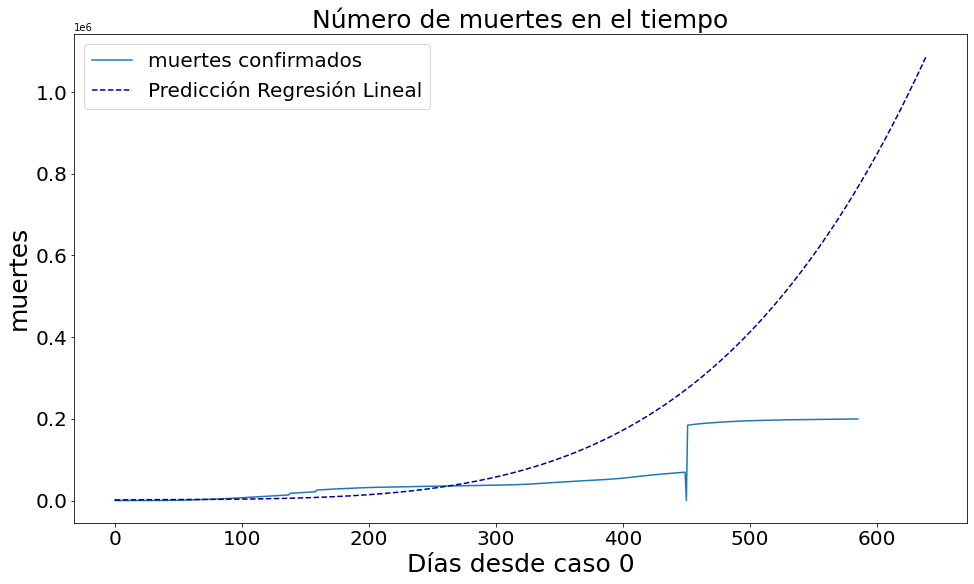

In [59]:
plot_predictions(adjusted_dates, peru_fallecidos, y_future_calc_n, 'Predicción Regresión Lineal', 'darkblue', 'muertes')

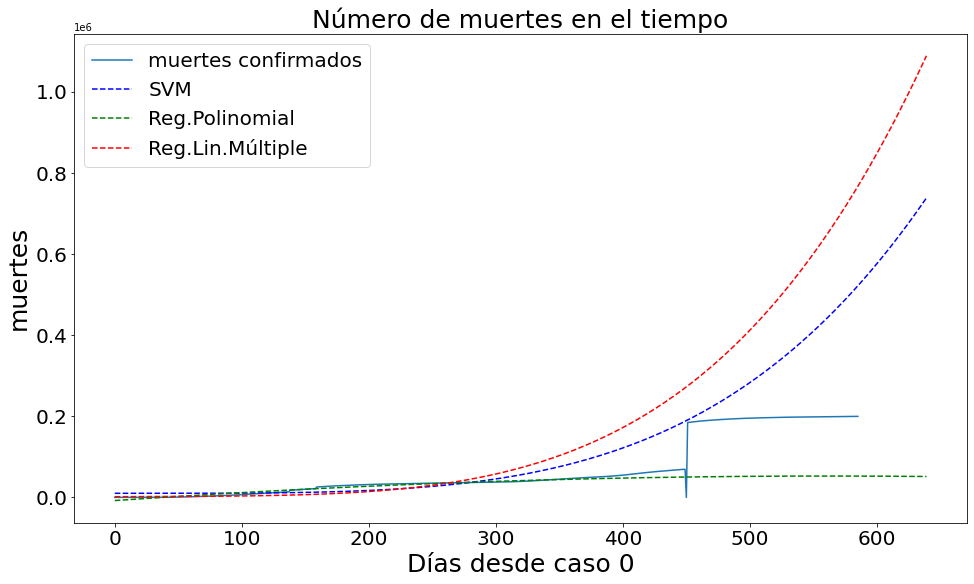

In [60]:
x = adjusted_dates
y = peru_fallecidos

algo_name1 = 'SVM'
algo_name2 = 'Reg.Polinomial'
algo_name3 = 'Reg.Lin.Múltiple'
title = 'muertes'
plt.figure(figsize=(16, 9))
plt.plot(x, y)
plt.plot(pronostico_futuro, svm_pred_fallecidos, linestyle='dashed', color='blue')
plt.plot(pronostico_futuro, linear_pred_fallecidos, linestyle='dashed', color='green')
plt.plot(pronostico_futuro, y_future_calc_n, linestyle='dashed', color='red')

#y_future_calc_n

plt.title('Número de ' + title + ' en el tiempo', size=25)
plt.xlabel('Días desde caso 0', size=25)
plt.ylabel(title, size=25)

plt.legend([title +' confirmados', algo_name1, algo_name2, algo_name3], prop={'size': 20})
#plt.legend([ title +' confirmados', algo_name2], prop={'size': 20})

plt.xticks(size=20)
plt.yticks(size=20)
plt.show()